# Advanced techniques

Let's explore feature engineering techniques with the house prices dataset from Kaggle.

We can find an illustrative example of how to use Deep feature synthesis [here](https://www.kaggle.com/willkoehrsen/featuretools-for-good), and a good explanation [here](https://stackoverflow.com/questions/52418152/featuretools-can-it-be-applied-on-a-single-table-to-generate-features-even-when).

The class `Dataset` with some helper functions is also available, in case you want to fork or pull request at [my GitHub repo](https://github.com/renero/class_notebooks/tree/master/src)

To work will all dependencies:

    git clone git@github.com:renero/class_notebooks.git
    cd class_notebooks
    pip install -r requirements.txt

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Advanced-techniques" data-toc-modified-id="Advanced-techniques-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Advanced techniques</a></span><ul class="toc-item"><li><span><a href="#Setup-the-dataset" data-toc-modified-id="Setup-the-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup the dataset</a></span><ul class="toc-item"><li><span><a href="#Feature-Creation" data-toc-modified-id="Feature-Creation-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Feature Creation</a></span></li><li><span><a href="#Scale-numerical-features" data-toc-modified-id="Scale-numerical-features-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Scale numerical features</a></span></li><li><span><a href="#Check-skewness" data-toc-modified-id="Check-skewness-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Check skewness</a></span></li><li><span><a href="#Check-correlation" data-toc-modified-id="Check-correlation-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Check correlation</a></span></li><li><span><a href="#Under-represented-features" data-toc-modified-id="Under-represented-features-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Under represented features</a></span></li><li><span><a href="#OneHot-encoding-for-categorical-variables." data-toc-modified-id="OneHot-encoding-for-categorical-variables.-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>OneHot encoding for categorical variables.</a></span></li><li><span><a href="#Baseline-basic-all-numeric-features" data-toc-modified-id="Baseline-basic-all-numeric-features-1.1.7"><span class="toc-item-num">1.1.7&nbsp;&nbsp;</span>Baseline basic all-numeric features</a></span></li></ul></li><li><span><a href="#Deep-Feature-Synthesis" data-toc-modified-id="Deep-Feature-Synthesis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Deep Feature Synthesis</a></span><ul class="toc-item"><li><span><a href="#Build-the-EntitySet" data-toc-modified-id="Build-the-EntitySet-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Build the EntitySet</a></span></li><li><span><a href="#Normalize-the-entity" data-toc-modified-id="Normalize-the-entity-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Normalize the entity</a></span></li><li><span><a href="#Deep-feature-synthesis" data-toc-modified-id="Deep-feature-synthesis-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Deep feature synthesis</a></span></li><li><span><a href="#Get-the-score!" data-toc-modified-id="Get-the-score!-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Get the score!</a></span></li></ul></li></ul></li></ul></div>

## Setup the dataset

In [1]:
import nbimporter
import numpy as np
import featuretools as ft
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import warnings

from copy import copy

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, \
        validation_curve, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore')

from dataset import Dataset

In [2]:
houses = Dataset('./data/houseprices_prepared.csv.gz')
houses.describe()

80 Features. 1460 Samples
Available types: [dtype('float64') dtype('O')]
  · 43 categorical features
  · 37 numerical features
  · 16 categorical features with NAs
  · 0 numerical features with NAs
  · 64 Complete features
--
Target: Not set


We will **replace the NA's** in the dataset with 'None' or 'Unknown' since they're not really NA's. For no good reason the person in charge of encoding the file decided to assign NA's to values where the feature does not apply, but instead of using a value for that special condition (like the string 'None') he/she decided to use the actual NA.

In [3]:
houses.replace_na(column='Electrical', value='Unknown')
houses.replace_na(column=houses.names('categorical_na'), value='None')
houses.set_target('SalePrice')
houses.describe()

79 Features. 1460 Samples
Available types: [dtype('float64') dtype('O')]
  · 43 categorical features
  · 36 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 79 Complete features
--
Target: SalePrice (float64)
'SalePrice'
  · Min.: 34900.0000
  · 1stQ: 129975.0000
  · Med.: 163000.0000
  · Mean: 180921.1959
  · 3rdQ: 214000.0000
  · Max.: 755000.0000


### Feature Creation

This is the part where we decide to remove or add features based on our knowledge on the data and phenomena being represented. In this case, we're removing the `Id` field, and summing up some of the numerical fields counting the nr. of bathrooms, porchs and square feet.

In [4]:
houses.drop_columns('Id')

houses.aggregate(['1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtFinSF2'], 'House_SF')
houses.aggregate(['OpenPorchSF','3SsnPorch','EnclosedPorch', 'ScreenPorch','WoodDeckSF'], 'Porch_sf')
houses.aggregate(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], 'Total_Baths')

houses.describe()

68 Features. 1460 Samples
Available types: [dtype('float64') dtype('O')]
  · 43 categorical features
  · 25 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 68 Complete features
--
Target: SalePrice (float64)
'SalePrice'
  · Min.: 34900.0000
  · 1stQ: 129975.0000
  · Med.: 163000.0000
  · Mean: 180921.1959
  · 3rdQ: 214000.0000
  · Max.: 755000.0000


### Scale numerical features

Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

In [5]:
houses.scale()
houses.describe()

68 Features. 1460 Samples
Available types: [dtype('float64') dtype('O')]
  · 43 categorical features
  · 25 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 68 Complete features
--
Target: SalePrice (float64)
'SalePrice'
  · Min.: 34900.0000
  · 1stQ: 129975.0000
  · Med.: 163000.0000
  · Mean: 180921.1959
  · 3rdQ: 214000.0000
  · Max.: 755000.0000


### Check skewness

In many modeling scenarios, normality of the features in a dataset is desirable. Power transforms are a family of parametric, monotonic transformations that aim to map data from any distribution to as close to a Gaussian distribution as possible in order to stabilize variance and minimize skewness.

In [6]:
houses.fix_skewness()
houses.describe()

68 Features. 1460 Samples
Available types: [dtype('float64') dtype('O')]
  · 43 categorical features
  · 25 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 68 Complete features
--
Target: SalePrice (float64)
'SalePrice'
  · Min.: 34900.0000
  · 1stQ: 129975.0000
  · Med.: 163000.0000
  · Mean: 180921.1959
  · 3rdQ: 214000.0000
  · Max.: 755000.0000


### Check correlation

There are 3 correlated columns to remove.
['TotRmsAbvGrd', 'GarageArea', 'House_SF']


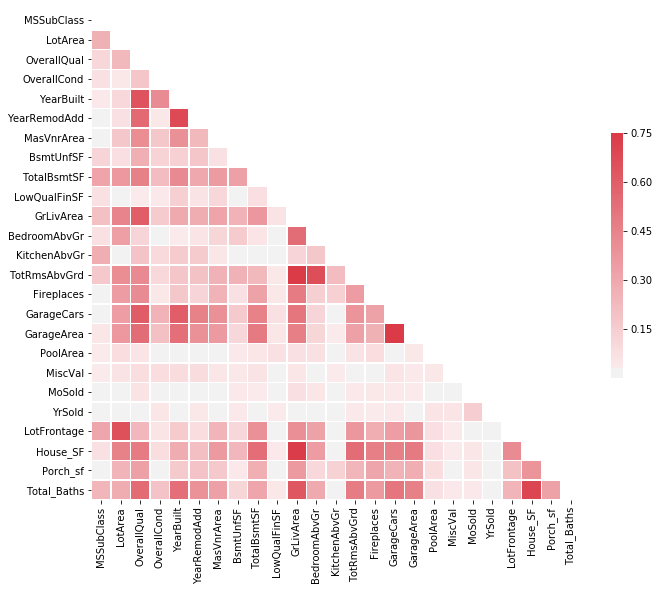

In [10]:
numericals_to_drop, corr_num = houses.numerical_correlated(threshold=0.7)
print('There are {} correlated columns to remove.'.format(
    len(numericals_to_drop)))
print(numericals_to_drop)
houses.plot_correlation_matrix(corr_num)

There are 2 correlated columns to remove.
['Exterior2nd', 'GarageCond']


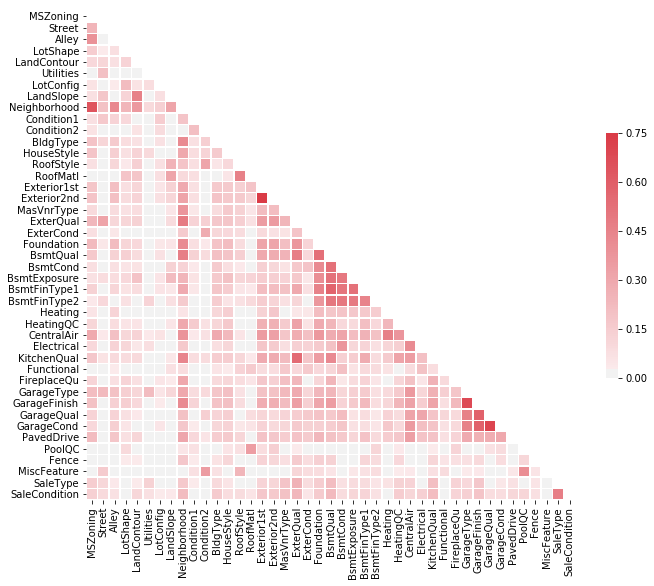

In [11]:
categoricals_to_drop, corr_categ = houses.categorical_correlated(threshold=0.7)
print('There are {} correlated columns to remove.'.format(
    len(categoricals_to_drop)))
print(categoricals_to_drop)
houses.plot_correlation_matrix(corr_categ)

In [12]:
houses.drop_columns(categoricals_to_drop + numericals_to_drop)
houses.describe()

63 Features. 1460 Samples
Available types: [dtype('float64') dtype('O')]
  · 41 categorical features
  · 22 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 63 Complete features
--
Target: SalePrice (float64)
'SalePrice'
  · Min.: 34900.0000
  · 1stQ: 129975.0000
  · Med.: 163000.0000
  · Mean: 180921.1959
  · 3rdQ: 214000.0000
  · Max.: 755000.0000


### Under represented features

In [13]:
urf = houses.under_represented_features()
print('Features with unrepresented categories:\n', urf)
houses.drop_columns(urf)
print(end='')
houses.describe();

Features with unrepresented categories:
 ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'PoolQC']
58 Features. 1460 Samples
Available types: [dtype('float64') dtype('O')]
  · 36 categorical features
  · 22 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 58 Complete features
--
Target: SalePrice (float64)
'SalePrice'
  · Min.: 34900.0000
  · 1stQ: 129975.0000
  · Med.: 163000.0000
  · Mean: 180921.1959
  · 3rdQ: 214000.0000
  · Max.: 755000.0000


### OneHot encoding for categorical variables.

Convert categorical variable into dummy/indicator variables. I use pandas `get_dummies` for this task. 

Beware of not using this before measuring correlation, as it will destroy your measurements.

In [14]:
houses_prepared = copy(houses)
houses.onehot_encode()
houses.describe()

243 Features. 1460 Samples
Available types: [dtype('float64')]
  · 0 categorical features
  · 243 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 243 Complete features
--
Target: SalePrice (float64)
'SalePrice'
  · Min.: 34900.0000
  · 1stQ: 129975.0000
  · Med.: 163000.0000
  · Mean: 180921.1959
  · 3rdQ: 214000.0000
  · Max.: 755000.0000


### Baseline basic all-numeric features

Time to assess what can a simple and multiple linear regression can do.

In [15]:
X, y = houses.split(test_size=0.2)

In [16]:
model = LinearRegression()
cv = ShuffleSplit(n_splits=1000, test_size=0.2, random_state=666)
scores = cross_val_score(model, 
                         X.train, y.train, 
                         cv=cv, 
                         scoring='r2')
print('Obtained {} positive R2 scores'.format(len(scores[scores > 0.0])))
print('Best Validation R2: {:.2f}'.format(max(scores)))
print('Avg. Validation R2: {:.2f}'.format(np.mean(scores[scores > 0.0])))

Obtained 22 positive R2 scores
Best Validation R2: 0.89
Avg. Validation R2: 0.78


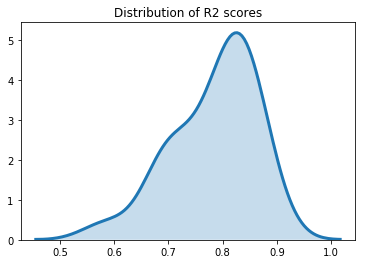

In [17]:
sns.distplot(scores[scores > 0.0], hist = False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 3});
plt.title('Distribution of R2 scores')
plt.show();

It seems that we can evaluate our regression problem using CV, but our 1'st degree polynomial is clearly too simple  (high biass) for this problem. The symptom of this is the **extremely negative values of the R2 scores** obtained.

To improve our solution, let's build a linear regression model with a **higher degree polynomial**. To do so, a Scikit Learn `Pipeline` is used, where `PolynomialFeatures` is used before the linear regression, to try out different `degree` polynomials.

`PolynomialFeatures` generates a new feature matrix consisting of all **polynomial combinations** of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

In [18]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=123)
pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    LinearRegression(n_jobs=-1)).fit(X.train, y.train)
scores = cross_val_score(pipeline, X.train, y.train,
                         scoring="r2", cv=cv)

print('Obtained {} positive R2 scores'.format(len(scores[scores > 0.0])))
print('Best CV R2: {:.2f}'.format(max(scores)))
print('Avg. CV R2: {:.2f} +/- {:.02}'.format(
    np.mean(scores[scores > 0.0]),
    np.std(scores[scores > 0.0])))
print('R2 in hold-out dataset: {:.2f}'.format(
    pipeline.score(X.test, y.test)))

Obtained 10 positive R2 scores
Best CV R2: 0.88
Avg. CV R2: 0.78 +/- 0.1
R2 in hold-out dataset: 0.86


With the information obtained in the cross validation process, I know that **I'm not overfitting**, so my results seem to be OK. The $R^2$ obtained is decent. But I don't know which of my splits is producing the best possible result. So, at this point, I can rely on a single fit, or I can try to use the model trained with the split that produces the best generalization error.

To do so:

  1. I use `cross_validate` method instead of `cross_val_score`, and I also specify that I want the estimator trained with each split to be returned
  2. I score all the different estimators to see which one is producing the best generalization error over the hold-out dataset (`X.test` and `y.test`).
  3. Compare the results obtained with a single estimator over the entire dataset, with the results obtained over a single split (the one producing the best results in generalization).

In [19]:
pipeline = Pipeline([
    ('polynomials', PolynomialFeatures(degree=2, include_bias=False)), 
    ('linear_regression', LinearRegression(n_jobs=-1))])
pipeline.fit(X.train, y.train)
training_score = pipeline.score(X.test, y.test)
print('R2 from entire-dataset estimator: {:.2f}'.format(training_score))

# Obtain scores and estimators from different splits and use the best one.
scores = cross_validate(pipeline, 
                        X.train, y.train,
                        scoring=['r2'], 
                        cv=5,
                        return_estimator=True)
split_scores = [scores['estimator'][i].score(X.test, y.test) 
                for i in range(len(scores))]
index_best = split_scores.index(max(split_scores))
print('Best estimator R2 score: {:.2f}'.format(split_scores[index_best]))

R2 from entire-dataset estimator: 0.86
Best estimator R2 score: 0.89


## Deep Feature Synthesis

Deep Feature Synthesis (DFS) is an automated method for performing feature engineering on relational and temporal data.

### Build the EntitySet

In [20]:
es = ft.EntitySet()
es = es.entity_from_dataframe(entity_id='houses', 
                              dataframe=pd.concat([houses_prepared.features, 
                                                   houses_prepared.target], 
                                                  axis=1),
                              index = 'Id')
es

2019-03-07 07:31:46,693 featuretools.entityset - WARNING    index Id not found in dataframe, creating new integer column


Entityset: None
  Entities:
    houses [Rows: 1460, Columns: 60]
  Relationships:
    No relationships

### Normalize the entity

In [21]:
es.normalize_entity(base_entity_id='houses', 
                    new_entity_id='houses_norm',
                    index='Id')
es

Entityset: None
  Entities:
    houses [Rows: 1460, Columns: 60]
    houses_norm [Rows: 1460, Columns: 1]
  Relationships:
    houses.Id -> houses_norm.Id

### Deep feature synthesis

In [22]:
f_matrix, f_defs = ft.dfs(entityset=es,
                          target_entity='houses_norm', 
                          verbose=1,
                          n_jobs=-1)

Built 210 features
EntitySet scattered to workers in 3.136 seconds
Elapsed: 00:11 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks

Exception ignored in: <generator object add_client at 0x1c22d3ca98>
RuntimeError: generator ignored GeneratorExit
tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError


Remove new variables that might be related to the target

In [23]:
drop_cols = []
for col in f_matrix:
    if col == houses_prepared.target.name:
        pass
    else:
        if houses_prepared.target.name in col:
            drop_cols.append(col)
            
print('Need to drop columns:', drop_cols)
f_matrix = f_matrix[[x for x in f_matrix if x not in drop_cols]]

Need to drop columns: ['SUM(houses.SalePrice)', 'STD(houses.SalePrice)', 'MAX(houses.SalePrice)', 'SKEW(houses.SalePrice)', 'MIN(houses.SalePrice)', 'MEAN(houses.SalePrice)']


In [24]:
# Create correlation matrix
corr_matrix = f_matrix.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]

print('Need to remove {} columns with >= 0.99 correlation.'.format(len(to_drop)))
f_matrix = f_matrix[[x for x in f_matrix if x not in to_drop]]

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:63710 remote=tcp://127.0.0.1:63680>


Need to remove 66 columns with >= 0.99 correlation.


Build a dataframe with the features created and the original ones to fit a regressor with it.

In [25]:
fs_df = pd.concat(
    [f_matrix, houses_prepared.features, houses_prepared.target], 
    axis=1)
fs = Dataset.from_dataframe(fs_df)
fs.describe()

197 Features. 1460 Samples
Available types: [dtype('float64') dtype('O')]
  · 72 categorical features
  · 125 numerical features
  · 0 categorical features with NAs
  · 44 numerical features with NAs
  · 153 Complete features
--
Target: Not set


Fix some parts that are not correct.

In [26]:
fs.replace_na(column=fs.names('numerical_na'), value=0)
fs.set_target(houses_prepared.target.name)
fs.onehot_encode()
fs.describe()

566 Features. 1460 Samples
Available types: [dtype('float64')]
  · 0 categorical features
  · 566 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 566 Complete features
--
Target: SalePrice (float64)
'SalePrice'
  · Min.: 34900.0000
  · 1stQ: 129975.0000
  · Med.: 163000.0000
  · Mean: 180921.1959
  · 3rdQ: 214000.0000
  · Max.: 755000.0000


### Get the score!

In [27]:
X, y = fs.split()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=123)
pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    LinearRegression(n_jobs=-1)).fit(X.train, y.train)
scores = cross_val_score(pipeline, X.train, y.train,
                         scoring="r2", cv=cv)

print('Obtained {} positive R2 scores'.format(len(scores[scores > 0.0])))
print('Best CV R2: {:.2f}'.format(max(scores)))
print('Avg. CV R2: {:.2f} +/- {:.02}'.format(
    np.mean(scores[scores > 0.0]),
    np.std(scores[scores > 0.0])))
print('R2 in hold-out dataset: {:.2f}'.format(
    pipeline.score(X.test, y.test)))

Obtained 10 positive R2 scores
Best CV R2: 0.88
Avg. CV R2: 0.78 +/- 0.1
R2 in hold-out dataset: 0.86
